# Creative extension

__Paper:__ Housing, Health, and Happiness

__Data:__ National Survey of America's Families, 2002

__Aim:__ 

1) Which living conditions affect which life outcomes (education, health or happiness) the most?

2) What is the effect of precarious housing on health (both physical and mental) and school involvement for children?

3) Following-up on aim 2: which age group (children[6,11] or adolescents[12,17]) is most impacted ?   

   
#### NB. A brief description of all the variables (what's being measured + scaling) can be found in the markdown file `Variables_description.md`

---

## Data pre-processing

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import math
import seaborn as sns
import scipy.stats as st
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms

In [2]:
# Make custom palettes for seaborn
colors = ['#BDDBD3','#B8B8FF'] #opal & lilac
#colors_light = ['#CAE2DC','#C2C2FF'] #opal & lilac
colors_light = ['#8FA3F8','#B6F3C9'] #light blue & light green
#colors_light = ['#CAF6D8','#B2BFFA'] #mint & lavender
#colors_dark=['#62A87C','#FDE74C']  #green & yellow
colors_dark = ['#9999FF','#B0D4CB'] #lilac & opal
customLight = sns.color_palette(colors_light)
customDark = sns.color_palette(colors_dark)
customPalette = sns.color_palette(colors)

In [3]:
# Load data

data_folder = './data/'
# Focal Child Data
fc = pd.read_stata(data_folder+'DS0001/04582-0001-Data.dta',convert_categoricals=False)
# Household Data
hh = pd.read_stata(data_folder+'DS0006/04582-0006-Data.dta',convert_categoricals=False)

In [4]:
# Variables of interest in child and hh datasets 
person_id = ['PERSID','PERSTYPE','SEX','UAGE','STATE','UREGION','HHID']
household_id_hh = ['HHID']
education = ['UENG','UENGNEG','UENGPOS','NLESSONS','CSPECED']
family = ['UFAMSTR','UMHIGDEG','UAGG']
family_hh = ['CHLD0_5','CHLD6_17','UHHCOUNT']
income = ['U_SOCPOV']
income_hh = ['QSC5']
housing_hh = ['MNBEDRMS','MOWNRENT'] #'OVERCROWDING' added later on
mental_health = ['UBPIA','UBPIANEG','UBPIAPOS','UBPIB','UBPIBNEG','UBPIBPOS','NCPROBC','UMH2']
health = ['BDISBL','BHLTHN']
activities = ['UACT']
sec = ['UHINS4'] 

# Add a variable 'overcrowding' and replace inf by -1
hh['OVERCROWDING'] = hh['UHHCOUNT'] / hh['MNBEDRMS']
housing_hh.append('OVERCROWDING')
hh['OVERCROWDING'] = hh['OVERCROWDING'].apply(lambda x : -1 if (x == np.inf or x < 0 or x >5) else x)

# Reduce dataframes to variables of interest
fc = fc[person_id + education + family + income + mental_health + health + activities + sec]
hh = hh[household_id_hh + family_hh + income_hh + housing_hh]

In [5]:
# Merge dataframes using the household ID number, 
# inner merge keeps only households that are linked to a focal child subject
child = pd.merge(fc, hh, left_on = 'HHID', right_on = 'HHID', how='inner')

# NaNs handling : replace all the missing/unusable values by -1
child.replace([-7,-8,-9],-1,inplace=True)

# Make the SEX variable binary with F=1 and M=0
child['SEX'].replace(to_replace=dict(F=1, M=0),inplace=True)
# Make the NLESSONS/CSPECED/BDISBL variable binary with Yes=1 and No=0
child['NLESSONS'].replace(2,0,inplace=True)
child['CSPECED'].replace(2,0,inplace=True)
child['BDISBL'].replace(2,0,inplace=True)
# Make the QSC5 variable (hh income vs 2x poverty line) binary with Below=0 and Above=1
child['QSC5'].replace({'1':0,'2':1,'':-1}, inplace=True)

# Normalize values for UENG(4-16), BHLTHN(1-5), UBPIA(6-18), UBPIB(6-18), UMH2(25-100), UACT(0-3), UAGG(4-16) & NCPROBC(1-3) (min-max)
child.loc[:,'UENGn'] = child['UENG'].apply(lambda x: (x-4)/(16-4) if x != -1 else x)
child.loc[:,'BHLTHNn'] = child['BHLTHN'].apply(lambda x: (x-1)/(5-1) if x != -1 else x)
child.loc[:,'UBPIAn'] = child['UBPIA'].apply(lambda x: (x-6)/(18-6) if x != -1 else x)
child.loc[:,'UBPIBn'] = child['UBPIB'].apply(lambda x: (x-6)/(18-6) if x != -1 else x)
child.loc[:,'UMH2n'] = child['UMH2'].apply(lambda x: (x-25)/(100-25) if x != -1 else x)
child.loc[:,'UACTn'] = child['UACT'].apply(lambda x: (x)/(3-0) if x != -1 else x)
child.loc[:,'UAGG'] = child['UAGG'].apply(lambda x: (16-x) if x != -1 else x)
child.loc[:,'UAGGn'] = child['UAGG'].apply(lambda x: x/(16-4) if x != -1 else x)
child.loc[:,'NCPROBC'] = child['NCPROBC'].apply(lambda x: 3-x if x != -1 else x)
child.loc[:,'NCPROBCn'] = child['NCPROBC'].apply(lambda x: x/2 if x != -1 else x)

# Preview of child dataframe
child.head()

,PERSID,PERSTYPE,SEX,UAGE,STATE,UREGION,HHID,UENG,UENGNEG,UENGPOS,...,MOWNRENT,OVERCROWDING,UENGn,BHLTHNn,UBPIAn,UBPIBn,UMH2n,UACTn,UAGGn,NCPROBCn
0,5561612801,1,1,3,WI,2,55616128,-1,-1,-1,...,1,0.75,-1.000000,0.00,-1.0,-1.000000,0.933333,-1.000000,0.000000,-1.0
1,5470400001,2,0,14,WI,2,54704000,8,1,0,...,2,1.50,0.333333,0.00,-1.0,0.416667,0.666667,0.333333,0.000000,0.5
2,5787427204,2,1,9,WI,2,57874272,12,0,0,...,2,2.00,0.666667,0.50,1.0,-1.000000,1.000000,0.666667,0.083333,0.0
3,5410681601,1,0,4,WI,2,54106816,-1,-1,-1,...,2,2.50,-1.000000,0.25,-1.0,-1.000000,0.666667,-1.000000,0.000000,-1.0
4,5051721601,2,1,17,WI,2,50517216,13,0,0,...,2,1.25,0.750000,0.25,-1.0,0.833333,0.253333,0.333333,0.416667,0.5


In [6]:
# Divide child data in 4 dfs based on age groups

# Keep data of focal children from age 0 to 17 only
child = child.loc[child['PERSTYPE'].isin([1,2])]

# are there young children (0-5yo) in household?
child.loc[:,'bool0_5'] = child['CHLD0_5'].apply(lambda x : 0 if x == 0 else 1)

# FC1 : focal children, aged 0-5
fc1 = child.copy()[child['PERSTYPE']==1]

# FC23 : focal children, aged 6-17
fc23 = child.copy()[child['PERSTYPE']==2]

# FC2 : focal children, aged 6-11
fc2 = child.copy()[(child['PERSTYPE']==2) & (child['UAGE'] < 12)]

# FC3 : focal children, aged 12-17
fc3 = child.copy()[(child['PERSTYPE']==2) & (child['UAGE'] >= 12)]

In [7]:
print(f'Shapes of dataframes:\nfc1: {fc1.shape}\nfc2: {fc2.shape}\nfc3:{fc3.shape}\nfc23: {fc23.shape}')
print((fc1.shape[0] + fc2.shape[0] + fc3.shape[0]) == child.shape[0]) #test to see if all children are counted

Shapes of dataframes:
fc1: (12268, 44)
fc2: (10925, 44)
fc3:(11087, 44)
fc23: (22012, 44)
True


---

# **1) Influence of living conditions on education, health and mental health**
In order to grasp which variables influence general outcome in life, we are linearly regressing these outcome variables on the living conditions variables.

In [8]:
# returns a dataframe where the rows of the given 'df' containing NaN values for either the 'outcome'
# or any of the 'predictors' have been removed
def df_NN(df,outcome,predictors):
    if len(predictors) <= 1:
        bools = (df[predictors[0]] != -1)
    else:
        bools = df[predictors].isin([-1]).any(axis=1)==False
    
    return df.loc[(df[outcome] != -1) & (bools)]

In [9]:
# returns a linear regression of the 'predictors' on the 'outcome', using only subjects in 'df' that answered
# to all the outcome and predictor questions
def res_NN(df,outcome,predictors):
    
    # df without rows containing NaNs for the outcome & predictors
    df_reg = df_NN(df,outcome,predictors)
    
    # model description
    model = outcome+' ~ '
    for i in range (0,len(predictors)):
        model = model+predictors[i]
        if i != len(predictors)-1 :    # if not last
            model = model+'+'
    
    # model fit, cluster std based on state        
    return smf.ols(formula=model, data=df_reg).fit(cov_type='cluster',cov_kwds={'groups': df_reg['STATE']})

## **1.1) Education: School involvement `UENG`**

In [10]:
outcome = 'UENG'
predictors = family+income+housing_hh+['SEX','UAGE','UACT','CSPECED']
res = res_NN(fc23,outcome, predictors)
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                   UENG   R-squared:                       0.183
Model:                            OLS   Adj. R-squared:                  0.183
Method:                 Least Squares   F-statistic:                     1444.
Date:                Wed, 16 Dec 2020   Prob (F-statistic):           1.52e-58
Time:                        22:27:32   Log-Likelihood:                -48931.
No. Observations:               21087   AIC:                         9.789e+04
Df Residuals:                   21075   BIC:                         9.798e+04
Df Model:                          11                                         
Covariance Type:              cluster                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       12.6909      0.177     71.762   

We can notice a few variables that have a strong impact on scholar involvement (those that have a small p-value and thus a large z-value):
- `SEX`: positive z indicates that being a female (F=1>0=M) is strongly positively associated with involvement.
- `UAGG`: negative z-value, meaning that higher parental aggravation is associated with worse school involvement.
- `UAGE`: Older children are negatively associated with involvement.
- `UACT`: Children that have a lot of extracurricular activities tend to perform better at school.
- `CSPECED`: As would be expected, children with special educationnal needs are less involved with school.
- `UFAMSTR`: School engagement becomes better when family structure has a higher index (**4** means living with both biological parents, **1** means living with no parents)

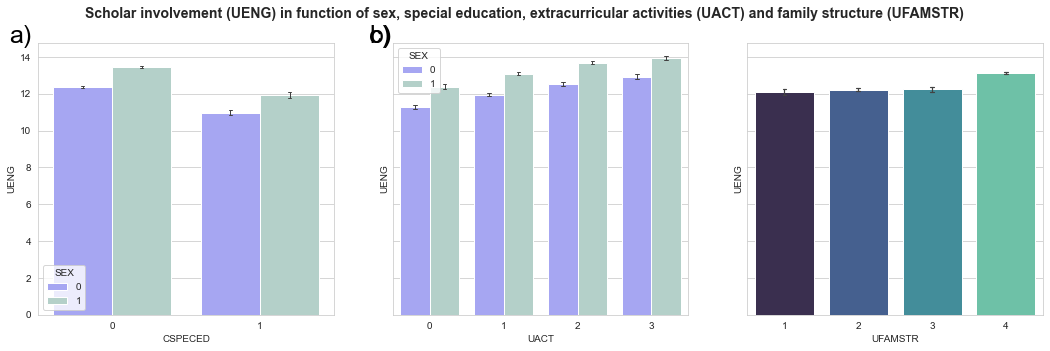

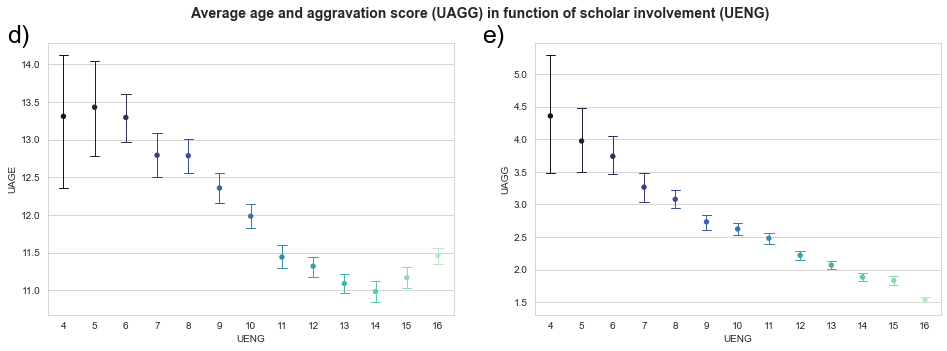

In [11]:
df = df_NN(fc23,outcome,predictors)
sns.set_style('whitegrid')
fig, axes = plt.subplots(1,3, figsize=(18,5), sharey=True)
axes[0].text(-0.1,1,'a)', fontsize=25, color='k', transform=axes[0].transAxes)
axes[1].text(-0.08,1,'b)', fontsize=25, color='k', transform=axes[1].transAxes)
axes[2].text(-0.08,1,'c)', fontsize=25, color='k', transform=axes[1].transAxes)
sns.barplot(ax=axes[0], y='UENG', x='CSPECED', hue='SEX', palette=customDark, data=df, capsize=0.02,errwidth=1)
sns.barplot(ax=axes[1], y='UENG', x='UACT', hue='SEX', palette=customDark, data=df, capsize=0.05,errwidth=1)
sns.barplot(ax=axes[2], y='UENG', x='UFAMSTR', palette='mako', data=df, capsize=0.05, errwidth=1.2)
plt.suptitle('Scholar involvement (UENG) in function of sex, special education, extracurricular activities (UACT) and family structure (UFAMSTR)', fontsize=14, fontweight='bold')
plt.show()
    
fig, axes = plt.subplots(1,2, figsize=(16,5))
axes[0].text(-0.1,1,'d)', fontsize=25, color='k', transform=axes[0].transAxes)
axes[1].text(-0.13,1,'e)', fontsize=25, color='k', transform=axes[1].transAxes)
sns.pointplot(ax=axes[0], x='UENG', y='UAGE', palette='mako', data=df,capsize=0.3,errwidth=1,markers='.')
sns.pointplot(ax=axes[1], x='UENG', y='UAGG', palette='mako', data=df,capsize=0.3,errwidth=1,markers='.')
plt.suptitle('Average age and aggravation score (UAGG) in function of scholar involvement (UENG)', fontsize=14, fontweight='bold')
plt.show()

**a)**   
**b)**   
**c)** Family structure `UFAMSTR` has an interesting effect on school involvement. Being under the supervision of two parents significantly improves scholar involvement. On the other hand, involvement is roughly the same for children brought up with no parents, 1 parent, or in a step-family. The latter fact is probably why `UFAMSTR` does not stand out as the most significant variable when linearly regressing it against `UENG` (compared to the other variables, with much higher z-values).  
**d)**  
**e)**  
___

## **1.2) Physical health: Poor health indicator `BHLTHN`**

In [12]:
outcome = 'BHLTHN'
predictors = family+income+housing_hh+['SEX','UAGE','UACT']
res = res_NN(fc23,outcome, predictors)
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                 BHLTHN   R-squared:                       0.108
Model:                            OLS   Adj. R-squared:                  0.108
Method:                 Least Squares   F-statistic:                     319.3
Date:                Wed, 16 Dec 2020   Prob (F-statistic):           1.12e-41
Time:                        22:27:35   Log-Likelihood:                -27112.
No. Observations:               21471   AIC:                         5.425e+04
Df Residuals:                   21460   BIC:                         5.433e+04
Df Model:                          10                                         
Covariance Type:              cluster                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        1.8017      0.076     23.767   

We can notice a few variables that have a strong impact on bad health indicator `BHLTHN`:
- `UACT`: Extracurricular activities are reducing the incidence of bad health.
- `U_SOCPOV`: The richer the family, the less unhealthy the child.
- `UMH2`: The better the parental mental health, the less unhealthy the child

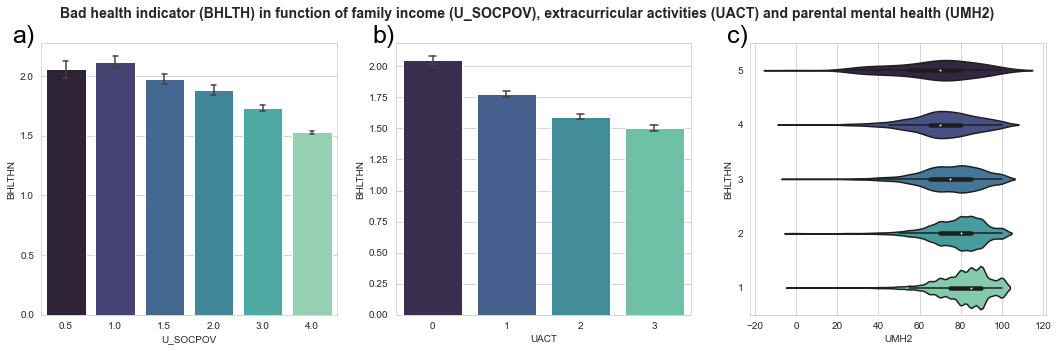

In [13]:
df = df_NN(fc23,outcome,predictors)
fig, axes = plt.subplots(1,3, figsize=(18,5))
axes[0].text(-0.1,1,'a)', fontsize=25, color='k', transform=axes[0].transAxes)
axes[1].text(-0.08,1,'b)', fontsize=25, color='k', transform=axes[1].transAxes)
axes[2].text(-0.08,1,'c)', fontsize=25, color='k', transform=axes[2].transAxes)
sns.barplot(ax=axes[0], y='BHLTHN', x='U_SOCPOV', palette='mako', data=df,capsize=0.1,errwidth=1.5)
sns.barplot(ax=axes[1], y='BHLTHN', x='UACT', palette='mako', data=df,capsize=0.1,errwidth=1.5)
sns.violinplot(ax=axes[2], x='UMH2', y='BHLTHN', palette='mako', data=df, orient='h',order=[5,4,3,2,1])
plt.suptitle('Bad health indicator (BHLTH) in function of family income (U_SOCPOV), extracurricular activities (UACT) and parental mental health (UMH2)', fontsize=14, fontweight='bold')
plt.show()

**a)** 
**b)** 
**c)**  

___

## **1.3) Mental health**

#### **1.3.1) Child mental health `NCPROBC`**

In [14]:
outcome = 'NCPROBC'
predictors = family+income+housing_hh+['SEX','UAGE','UACT']
res = res_NN(fc23,outcome, predictors)
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                NCPROBC   R-squared:                       0.130
Model:                            OLS   Adj. R-squared:                  0.130
Method:                 Least Squares   F-statistic:                     573.1
Date:                Wed, 16 Dec 2020   Prob (F-statistic):           6.11e-48
Time:                        22:27:37   Log-Likelihood:                -16317.
No. Observations:               21414   AIC:                         3.266e+04
Df Residuals:                   21403   BIC:                         3.274e+04
Df Model:                          10                                         
Covariance Type:              cluster                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        0.2977      0.036      8.322   

We can notice a few variables that have a strong impact on child depression/sadness index `NCPROBC`:
- `UAGE`: Mental health of children gets poorer with age.
- `UFAMSTR`: The richer the family, the less unhealthy the child.
- `UAGG`: Parental aggravation is positively correlated with child depression.
- `UMH2`: The better the parental mental health, the better the child's.

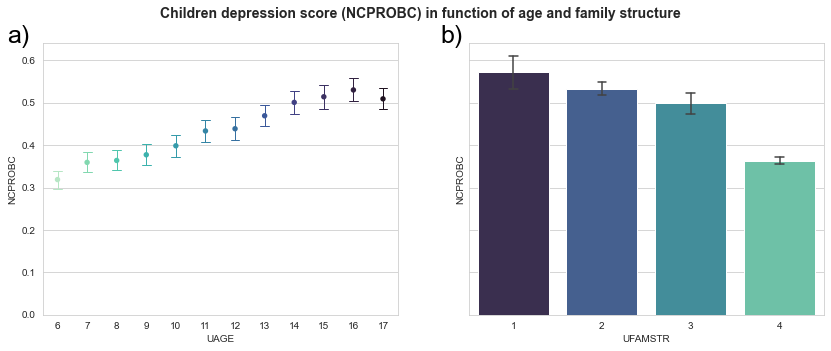

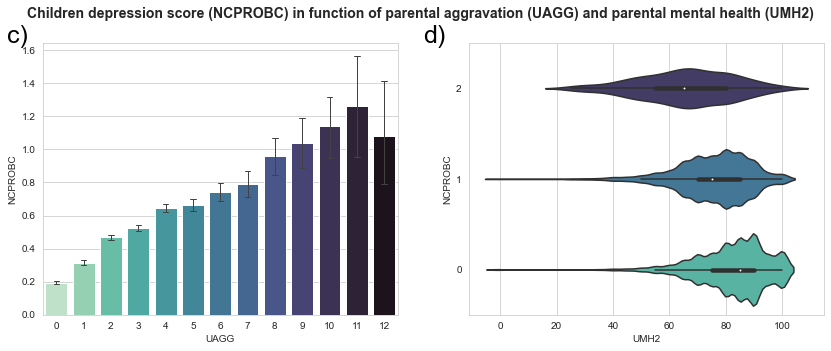

In [15]:
df=df_NN(fc23,outcome,predictors)
fig, axes = plt.subplots(1,2, figsize=(14,5), sharey=True)
axes[0].text(-0.1,1,'a)', fontsize=25, color='k', transform=axes[0].transAxes)
axes[1].text(-0.08,1,'b)', fontsize=25, color='k', transform=axes[1].transAxes)
sns.pointplot(ax=axes[0], x='UAGE', y='NCPROBC', palette='mako_r', data=df,capsize=0.3,errwidth=1,markers='.')
sns.barplot(ax=axes[1], y='NCPROBC', x='UFAMSTR', palette='mako', data=df,capsize=0.1,errwidth=1.5)
plt.suptitle('Children depression score (NCPROBC) in function of age and family structure', fontsize=14, fontweight='bold')
plt.show()
    
fig, axes = plt.subplots(1,2, figsize=(14,5))
axes[0].text(-0.1,1,'c)', fontsize=25, color='k', transform=axes[0].transAxes)
axes[1].text(-0.13,1,'d)', fontsize=25, color='k', transform=axes[1].transAxes)
sns.barplot(ax=axes[0], x='UAGG', y='NCPROBC', palette='mako_r', data=df,capsize=0.2,errwidth=1)
sns.violinplot(ax=axes[1], x='UMH2', y='NCPROBC', palette='mako', data=df, orient='h',order=[2,1,0])
plt.suptitle('Children depression score (NCPROBC) in function of parental aggravation (UAGG) and parental mental health (UMH2)', fontsize=14, fontweight='bold')
plt.show()

**a)** 
**b)** 
**c)**
**d)**

#### **1.3.2) Parents' mental health `UMH2`**

In [16]:
outcome = 'UMH2'
predictors = family_hh+income+housing_hh+['SEX','BDISBL','UAGG']
res = res_NN(child,outcome, predictors)
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                   UMH2   R-squared:                       0.161
Model:                            OLS   Adj. R-squared:                  0.161
Method:                 Least Squares   F-statistic:                     370.8
Date:                Wed, 16 Dec 2020   Prob (F-statistic):           2.84e-43
Time:                        22:27:39   Log-Likelihood:            -1.3095e+05
No. Observations:               33466   AIC:                         2.619e+05
Df Residuals:                   33455   BIC:                         2.620e+05
Df Model:                          10                                         
Covariance Type:              cluster                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       77.4133      0.940     82.327   

We can notice a few variables that have a strong impact on parental mental health `UMH2`:
- `U_SOCPOV`: The wealthier, the better the mental health.
- `BDISBL`: The mental health of the parents is worse when the child has a disability.
- `UAGG`: As expected, the more aggravating a child is, the worse the parent's mental health.

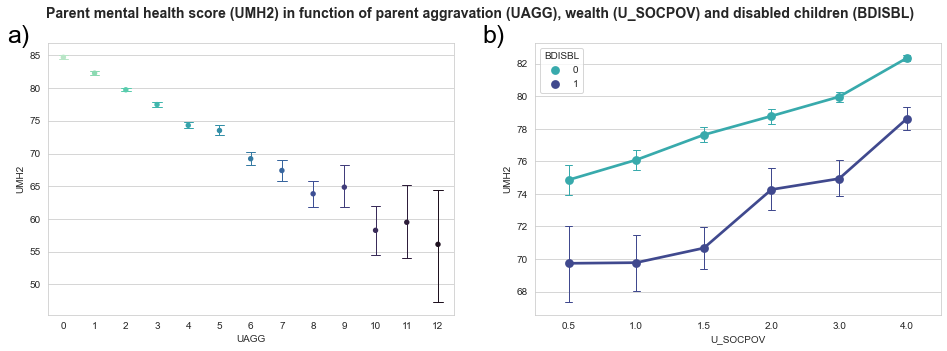

In [17]:
df = df_NN(child,outcome,predictors)
fig, axes = plt.subplots(1,2, figsize=(16,5))
axes[0].text(-0.1,1,'a)', fontsize=25, color='k', transform=axes[0].transAxes)
axes[1].text(-0.13,1,'b)', fontsize=25, color='k', transform=axes[1].transAxes)
sns.pointplot(ax=axes[0], x='UAGG', y='UMH2', palette='mako_r', data=df,capsize=0.3,errwidth=1,markers='.')
sns.pointplot(ax=axes[1], x='U_SOCPOV', y='UMH2', hue='BDISBL', palette='mako_r', data=df, capsize=0.1, errwidth=1)
plt.suptitle('Parent mental health score (UMH2) in function of parent aggravation (UAGG), wealth (U_SOCPOV) and disabled children (BDISBL)', fontsize=14, fontweight='bold')
plt.show()

**a)** 
**b)** 

---

## **2) Impact of precarious living conditions on Education, Physical and Mental health of children**

We first have to define what a precarious environment is. For this, we establish a new variable called `living_ind` which gives a score reflective of the quality of life. We use the people per bedroom `OVERCROWDING`, family structure `UFAMSTR`, household ownership `MOWNRENT`, parental aggravation score `UAGG`, insurance `UHINS4` and household income `U_SOCPOV` to define and quantify our index.  
Looking at the distribution of living indices [`living_ind`.describe()], we then decide on a threshold that indicates that any household with a value under said threshold is considered precarious. We establish a boolean `precarious` variable that is **1** if the household is precarious and **0** if not.  
NB. Our threshold is 0; a negative `living_ind` indicates precarity and a positive one does not.

In [18]:
# Variables used for precarity indicator (economics and relationship with family)
prec = ['U_SOCPOV','OVERCROWDING','MOWNRENT','UHINS4','UAGG','UFAMSTR']

df_prec = df_NN(fc23,'PERSID',prec)

In [19]:
# Living conditions indicator
negative = ['OVERCROWDING','MOWNRENT','UHINS4']
positive = ['U_SOCPOV','UAGG','UFAMSTR']
    
# Normalize all the variables and sign them 
# NB performs column-wise automatically
norm_prec =(df_prec[prec]-df_prec[prec].min())/(df_prec[prec].max()-df_prec[prec].min())
norm_prec.loc[:,negative] *= -1

# Add custom weights for different variables
weights = [2.5,7,0.5,0.5,0.25,2]

# Compute living conditions indicator
norm_prec.loc[:,'living_ind'] = norm_prec.dot(weights)

# Choose a threshold to consider a household 'precarious' or not (we chose the value 0)
threshold = 0
norm_prec.loc[:,'precarious'] = norm_prec['living_ind'].apply(lambda x : 1 if x < threshold else 0)

print(norm_prec['living_ind'].describe())

count    21515.000000
mean         1.371713
std          1.704213
min         -7.708333
25%          0.214286
50%          1.691964
75%          2.847222
max          4.187500
Name: living_ind, dtype: float64


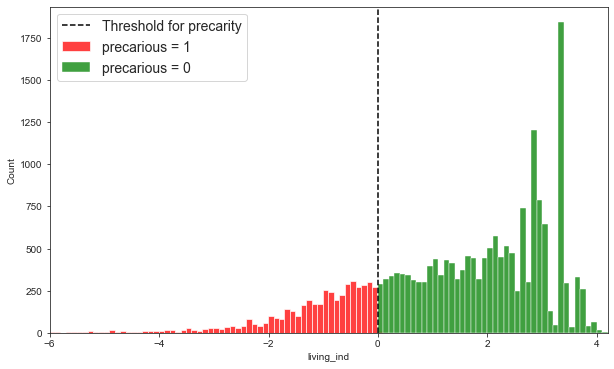

In [20]:
sns.set_style('ticks')
fig, axes = plt.subplots(1,figsize=(10,6))
sns.histplot(ax=axes, data = norm_prec[norm_prec['precarious']==1]['living_ind'], binwidth=0.1,color='r')
sns.histplot(ax=axes, data = norm_prec[norm_prec['precarious']==0]['living_ind'], binwidth=0.1, color='g')
plt.axvline(threshold,color='k',linestyle='--')
plt.xlim(-6,4.2)
plt.legend(['Threshold for precarity','precarious = 1','precarious = 0'],fontsize=14)
plt.show()

Looking at the `living_ind` description, we can infer that less than 25% of surveyed children live under precarious conditions (as the 25% quantile is slightly over the threshold of 0).  
Let's add the `precarious` boolean to our dataframe containing children aged 6-17:

In [21]:
fc23_prec = pd.merge(fc23, norm_prec['precarious'], left_index=True, right_index=True, how='inner')

We would now like to highlight the effect of being born in a `precarious` household on education, physical and mental health. We could simply graph the different outcomes with respect to the `precarious` binary hue, but this would not account for the different covariates (such as parental educationnal degree, sex and age) that will without a doubt have significant interactions coefficients.  
We therefore decided to implement a __**Propensity Score Matching (PSM)**__. For this, we first assign a propensity score (PS) to each subject, which represents the likelihood to be in a precarious household, based on covariate information. Then, we match subjects who had similar propensity scores but still ended up in the two different subpopulations (precarious and not). This creates 2 subsets of individuals which have extremely similar distributions of the covariates but are still divided based on the precarity 'treatment', which allows us to quantify the effect of the latter.

## **2.1) Propensity score establishment**
Let's first make an example of PSM using the treatment variable `bool0_5`, which shows whether or not a household has a young child (0-5 years old). we would like to highlight the effects of having young children in the household.  

#### **PS with `precarious` as treatment**
We first need to establish a logistic regression of `bool0_5` on the covariates, which we train using the entire available dataset.

In [22]:
# logistic regression for CHLD0_5
predictors= ['SEX','UREGION','UFAMSTR','UMH2','UMHIGDEG','UAGG','UHHCOUNT','U_SOCPOV','MNBEDRMS','MOWNRENT','OVERCROWDING','BDISBL','UHINS4','NCPROBC']
df_05 = df_NN(fc23,'bool0_5',predictors)

log_model_1 = 'bool0_5 ~ SEX + UREGION + UFAMSTR + UMH2 + UMHIGDEG + UAGG + UHHCOUNT + U_SOCPOV + MNBEDRMS + MOWNRENT + OVERCROWDING + BDISBL + UHINS4 + NCPROBC'

log1 = smf.logit(formula=log_model_1, data=df_05)
res1 = log1.fit()
res1.summary()

Optimization terminated successfully.
         Current function value: 0.497028
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                bool0_5   No. Observations:                21388
Model:                          Logit   Df Residuals:                    21371
Method:                           MLE   Df Model:                           16
Date:                Wed, 16 Dec 2020   Pseudo R-squ.:                  0.1653
Time:                        22:27:42   Log-Likelihood:                -10630.
converged:                       True   LL-Null:                       -12735.
Covariance Type:            nonrobust   LLR p-value:                     0.000
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       -4.0951      0.214    -19.155      0.000      -4.514      -3.676
UREGION[T.2]    -0.0138      0.049     -0.282      0.778      -0.110       0.082
UREGION[T.3]     0.0233      0.050      0.469      0.639      -0.074       0.121
UREGION[T.4]     0.0010      0.051      0.020      0.984      -0.099       0.101
SEX              0.0014      0.034      0.041      0.967      -0.066       0.068
UFAMSTR         -0.0123      0.020     -0.621      0.535      -0.051       0.027
UMH2             0.0066      0.001      4.648      0.000       0.004       0.009
UMHIGDEG        -0.0239      0.009     -2.617      0.009      -0.042      -0.006
UAGG             0.0291      0.010      2.928      0.003       0.010       0.049
UHHCOUNT         0.7226      0.029     24.551      0.000       0.665       0.780
U_SOCPOV        -0.2050      0.018    -11.651      0.000      -0.239      -0.170
MNBEDRMS        -0.1381      0.042     -3.315      0.001      -0.220      -0.056
MOWNRENT         0.2268      0.039      5.863      0.000       0.151       0.303
OVERCROWDING     0.3144      0.073      4.280      0.000       0.170       0.458
BDISBL          -0.2739      0.054     -5.031      0.000      -0.381      -0.167
UHINS4          -0.0901      0.020     -4.446      0.000      -0.130      -0.050
NCPROBC          0.0137      0.034      0.406      0.685      -0.052       0.080
================================================================================
"""

We can now assign a number to each individual, by evaluating the logistic regression with their covariates, which yields a number $\in$ [0-1], the propensity score. The testing set is precisely the training set.

In [23]:
# from the logistic regression, compute the predicted propensity from the training set
pred05 = res1.predict(df_05.copy())
df_05.loc[:,'PS'] = pred05

C:\Users\alanh\anaconda3\lib\site-packages\pandas\core\indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\alanh\anaconda3\lib\site-packages\pandas\core\indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


## **2.2) Matching**
We now need to perform 1-to-1 matching of individuals (from the treatment and control subpop.) with similar PS. For this, we use our implemented `optimatch` method which, for each treated individual, finds the individual from the control set with the closest PS (`find_nearest` method) and matches them together if and only if the difference in PS is smaller than a certain threshold value alpha (we will use 0.01 by default, which is quite a low threshold and will thus yield very strict matchings).   


`plotPS` is a method that takes care of the matching and additionnally graphs:
- the propensity score distributions of the two subpopulations (control and treatment) before and after matching
- the distribution of a variable of choice, inputted as `var` in the method. By choosing a covariate (used in the PS) as the plotted `var`, we can visualize the distribution of said covariate pre- and post-matching.

#### Useful methods

In [24]:
# Finds closest PS to the input 'score' from the inputted array 'array'.
# Returns value of PS and its difference with 'score'.
def find_nearest(array, score):
    array = np.asarray(array)
    idx = (np.abs(array - score)).argmin()
    matchps = array[idx]
    return matchps, np.abs(matchps-score)

In [25]:
# Returns a dataframe containing two equally numbered populations (control, treatment) with ideally matched propensity scores
def optimatch(ctrl_df,trtm_df,alpha=0.01):
    idx=[]
    idtrtm=[]
    if (trtm_df.shape[0] > ctrl_df.shape[0]): # we iterate over the smaller dataframe and use the other one as a pool
        trtm_df, ctrl_df = ctrl_df, trtm_df
    iterative_df = trtm_df.reset_index(drop=True).copy().sample(frac=1) # shuffles the df so that we don't always preferentially optimize the first rows
    pool_df = ctrl_df.reset_index(drop=True).copy()
    for i in range(0,iterative_df.shape[0]):
        ps = iterative_df.iloc[i].PS
        matched, diff = find_nearest(pool_df.PS.drop(idx),ps)
        if (diff < alpha):
            idx.append(pool_df[pool_df.PS == matched].index[0]) 
            idtrtm.append(i)
    return pool_df.iloc[idx].append(iterative_df.iloc[idtrtm])

In [26]:
# plots the matched vs unmatched repartition of 1) Propensity score and 2) a random variable var, option to return the matched dataframe
def plotPS(unmatched,treatment,var,ret=False):
    
    treated = unmatched[unmatched[treatment]==1].sample(frac=1).reset_index(drop=True)
    control = unmatched[unmatched[treatment]==0].sample(frac=1).reset_index(drop=True)
    
    matched = optimatch(treated,control,0.001)
    
    # the sizes can tell us how many individuals the alpha threshold weeds out
    print(f'Number of treated subjects : {treated.shape[0]} \n\
Number of control subjects : {control.shape[0]} \n\
Number of matched pairs : {matched[matched[treatment]==1].shape[0]}')
    
    fig, axes = plt.subplots(1,2, figsize=(20,5),sharey=True)
    axes[0].text(-0.1,1,'a)', fontsize=25, color='k', transform=axes[0].transAxes)
    axes[0].text(0.8,0.7,'pre-matching', fontsize=15, color='k', transform=axes[0].transAxes)
    axes[1].text(-0.05,1,'b)', fontsize=25, color='k', transform=axes[1].transAxes)
    axes[1].text(0.8,0.7,'post-matching', fontsize=15, color='k', transform=axes[1].transAxes)
    sns.histplot(ax = axes[0], data=unmatched, x="PS", hue=treatment, kde=True, element='step', stat='density', common_norm=False, palette= customDark)
    sns.histplot(ax = axes[1], data=matched, x="PS", hue=treatment, kde=True, element='step', stat='density', common_norm=False, palette = customDark)
    plt.suptitle('Propensity score distribution for unmatched and matched samples', fontsize=14, fontweight='bold')
    plt.show()
    
    fig, axes = plt.subplots(1,2, figsize=(20,5),sharey=True)
    axes[0].text(-0.1,1,'c)', fontsize=25, color='k', transform=axes[0].transAxes)
    axes[0].text(0.8,0.7,'pre-matching', fontsize=15, color='k', transform=axes[0].transAxes)
    axes[1].text(-0.05,1,'d)', fontsize=25, color='k', transform=axes[1].transAxes)
    axes[1].text(0.8,0.7,'post-matching', fontsize=15, color='k', transform=axes[1].transAxes)
    sns.kdeplot(ax=axes[0], data=unmatched, x=var, hue=treatment, palette='mako', shade=True, common_norm=False)
    sns.kdeplot(ax=axes[1], data=matched, x=var, hue=treatment, palette='mako', shade=True)
    axes[0].set_xlim(0,5)
    axes[1].set_xlim(0,5)
    plt.suptitle(var+' distribution for unmatched and matched samples', fontsize=14, fontweight='bold')
    plt.show()
    
    if(ret):
        return matched

---

Number of treated subjects : 6045 
Number of control subjects : 15343 
Number of matched pairs : 5153


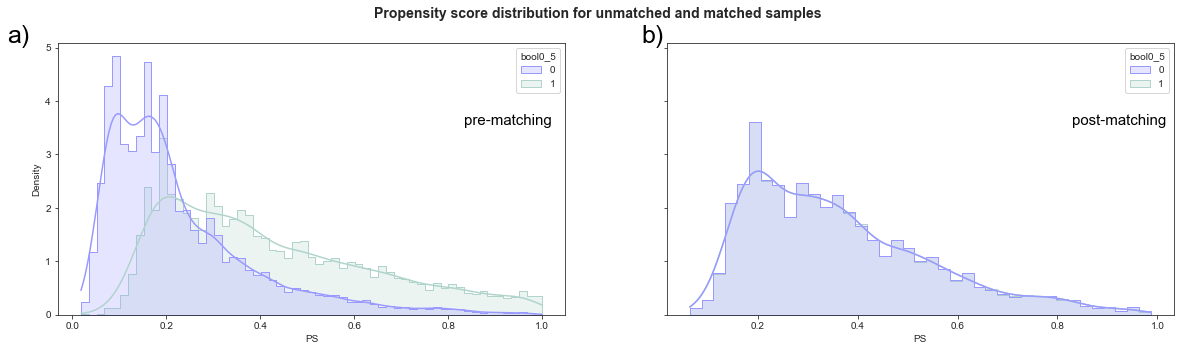

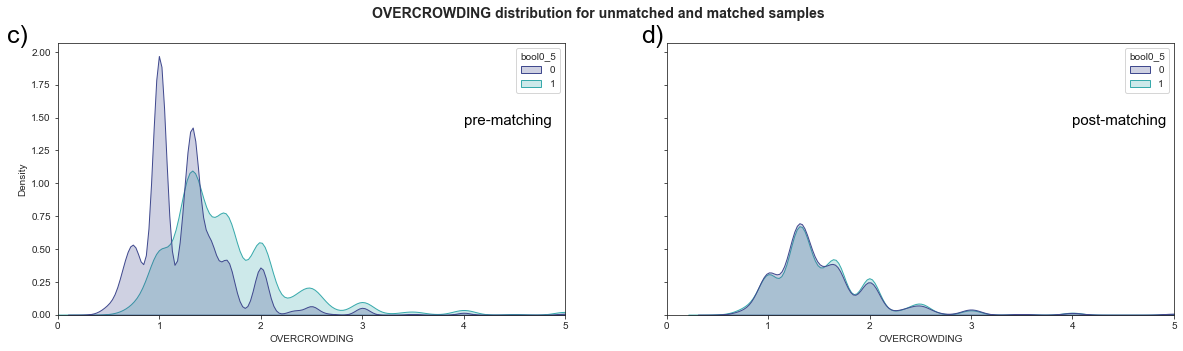

In [27]:
plotPS(df_05,'bool0_5','OVERCROWDING')

First of all, we can see that the matching method returns about 5'000 pairs (from an initial treatment set of $\approx$ 6'000), meaning we lose about a sixth of the treated subjects in the process. We believe this to be a good result considering the tightness of the alpha threshold we chose (0.01). 

Looking at graphs **a)** and **b)**, which represent the PS distributions pre- and post-matching respectively, we notice that indeed, the matching selects for individual pairs with extremely similar PSs. The two populations (treatment and control) are effectively undistinguishable on plot **b)**, which is again a testimony to the small alpha coefficient.

Looking at plots **c)** and **d)**, which represent the covariate (`OVERCROWDING`) distributions pre- and post-matching respectively, we notice that indeed, the matching selects for individual pairs with extremely similar covariate values. We can notice that pre-matching, the treated population (with young children, in green) has on average a higher `OVERCROWDING` value. This is intuitive as our treatment choice involved the presence of at least one child, meaning that in the absence of other information, it is safe to assume that households with additional people (treatment) can only be more overcrowded than their control counterpart.  
Plot **d)** shows the extreme homogeneity of the covariate post-matching.



#### **PS with `precarious` as treatment**
Let us now do the same process with the `precarious` treatment this time. The covariates include (non-exhaustively) age `UAGE`, sex `SEX`, geographical region `UREGION`, overcrowding `OVERCROWDING`, the number of activities the child takes part in `UACT`...

In [28]:
# logistic regression for precarious

predictors= ['SEX','UAGE','UREGION','UMHIGDEG','UHHCOUNT','MNBEDRMS','OVERCROWDING','BDISBL','CSPECED','UACT']
df_prec_raw = df_NN(fc23_prec,'precarious',predictors)

log_model_prec = 'precarious ~ SEX + UAGE + UREGION + UMHIGDEG + UHHCOUNT + MNBEDRMS + OVERCROWDING + BDISBL + CSPECED + UACT'

log_prec = smf.logit(formula=log_model_prec, data=df_prec_raw)
res_prec = log_prec.fit()
res_prec.summary()

Optimization terminated successfully.
         Current function value: 0.385589
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:             precarious   No. Observations:                21317
Model:                          Logit   Df Residuals:                    21304
Method:                           MLE   Df Model:                           12
Date:                Wed, 16 Dec 2020   Pseudo R-squ.:                  0.2657
Time:                        22:27:54   Log-Likelihood:                -8219.6
converged:                       True   LL-Null:                       -11194.
Covariance Type:            nonrobust   LLR p-value:                     0.000
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       -1.3223      0.270     -4.900      0.000      -1.851      -0.793
UREGION[T.2]    -0.2333      0.060     -3.910      0.000      -0.350      -0.116
UREGION[T.3]     0.4243      0.056      7.607      0.000       0.315       0.534
UREGION[T.4]     0.0734      0.060      1.226      0.220      -0.044       0.191
SEX              0.1324      0.040      3.330      0.001       0.054       0.210
UAGE             0.0121      0.006      2.139      0.032       0.001       0.023
UMHIGDEG         0.0168      0.010      1.643      0.100      -0.003       0.037
UHHCOUNT         0.1807      0.053      3.419      0.001       0.077       0.284
MNBEDRMS        -0.8585      0.085    -10.143      0.000      -1.024      -0.693
OVERCROWDING     1.3963      0.150      9.331      0.000       1.103       1.690
BDISBL           0.3663      0.066      5.591      0.000       0.238       0.495
CSPECED          0.2227      0.066      3.383      0.001       0.094       0.352
UACT            -0.4732      0.022    -21.590      0.000      -0.516      -0.430
================================================================================
"""

In [29]:
pred_prec = res_prec.predict(df_prec_raw)
df_prec_raw.loc[:,'PS'] = pred_prec

C:\Users\alanh\anaconda3\lib\site-packages\pandas\core\indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\alanh\anaconda3\lib\site-packages\pandas\core\indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


Number of treated subjects : 4660 
Number of control subjects : 16657 
Number of matched pairs : 3466


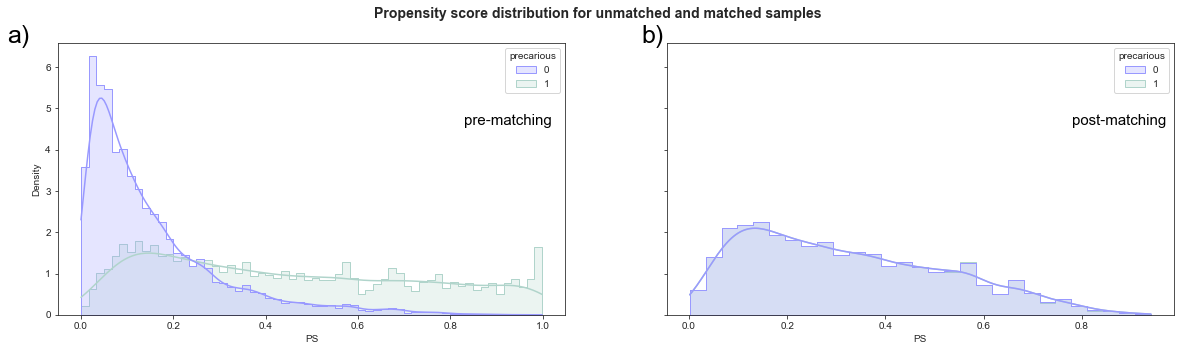

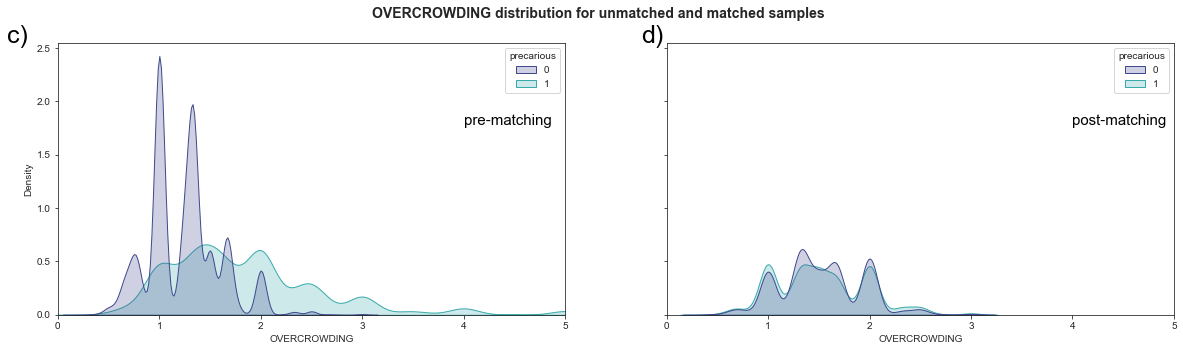

In [30]:
df_prec = plotPS(df_prec_raw,'precarious','OVERCROWDING',True)

The same conclusions can be said as with the `bool0_5` treatment; matching is sucessful and we can now look at the treatment effects.

## **2.3) ATE**
by looking at the difference of a certain variable $y$ in control and treatment groups, we can calculate the Average Treatment Effect (ATE) as 
$$ATE = \frac{1}{N} \sum_i^N  y_{treat}^{(i)} - y_{ctrl}^{(i)}$$  
$$\overline{ATE}= \bar{y}_{treat} - \bar{y}_{ctrl}$$  
We must be careful of choosing variables which are not used in the PS (otherwise the ATE will be zero).  

The reason we performed PSM in the first place was to get an accurate ATE for the `precarious` treatment alone, not an ATE that has the influence of covariates, and thus would not be very representative. Let's graphically and numerically check that indeed the ATEs calculated pre- and post-matching are different:

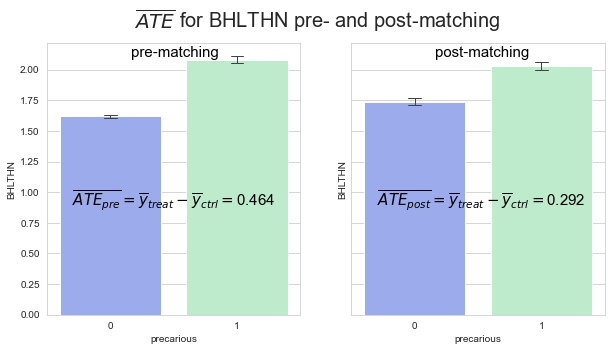

In [31]:
var='BHLTHN'
means_prec_raw = df_prec_raw.groupby('precarious').mean()
means_prec = df_prec.groupby('precarious').mean()

with sns.axes_style("whitegrid"):
    pre = str(round(means_prec_raw[var][1] - means_prec_raw[var][0],3))
    post = str(round(means_prec[var][1] - means_prec[var][0],3))
    fig, axes = plt.subplots(1,2,figsize=(10,5),sharey=True)
    axes[0].text(0.33,0.95,'pre-matching', fontsize=15, color='k', transform=axes[0].transAxes)
    axes[0].text(0.1,0.4,'$\overline{ATE_{pre}} = \overline{y}_{treat} - \overline{y}_{ctrl} = $'+pre, fontsize=15, color='k', transform=axes[0].transAxes)
    axes[1].text(0.33,0.95,'post-matching', fontsize=15, color='k', transform=axes[1].transAxes)
    axes[1].text(0.1,0.4,'$\overline{ATE_{post}} = \overline{y}_{treat} - \overline{y}_{ctrl} = $'+post, fontsize=15, color='k', transform=axes[1].transAxes)
    sns.barplot(ax = axes[0], data=df_prec_raw,x='precarious',y=var, palette=customLight,capsize=0.1,errwidth=1)
    sns.barplot(ax = axes[1], data=df_prec,x='precarious',y=var, palette=customLight,capsize=0.1,errwidth=1)
    
    plt.suptitle('$\overline{ATE}$ for '+str(var)+' pre- and post-matching', fontsize=20)

We can indeed see from the plot above that PSM changes the ATE compared to the unmatched data. This is explained by the fact that the model on the left (pre-matching) still has the influence of all the covariates __*__ associated with the `precarious` treatment. We can thus conclude that the matching has the desired effect on the ATEs we wish to measure.  

__*__ As the ATE is lowered by the matching, we can assume that most `precarious`-covariates have a positive correlation with the chosen variable `BHLTHN`, which overinflates the raw ATE, misleading uncareful observers at first glance. This is a common statistical fallacy used to manipulate results and especially conclusions.

We now want to compare the ATEs of `precarious` for different variables. Unfortunately, ATEs are still in the unit of the $y$ variable, meaning it is not comparable with other ATEs.  
One way to circumvent that issue is to normalize the variables $y$ into $y_n$ $\in [0;1]$. This way, the ATE is expressed as a percentage change and is thus unitless and can be compared with limitless other variables of interest $y_n$. Let's try to plot mutliple ATEs on the same graph to recapitulate the different effects:

## **2.4 ATEs of precarity on school, health & happiness**
We designed a method `ATE_sch_hlth_happ` that returns a dataframe containing:
- the normalized variables of interest (can be manually imputted). We are using an education variable (`UENGn`), a health variable (`BHLTHNn`), several mental health variables (child: `NCPROBCn`, `UBPIAn`, `UBPIBn`, parent: `UMH2n` and `UAGGn`) and a control variable (`UACTn`__*__) 

- the respective means of the normalized ATE,  $\overline{ATE}$
- 3 confidence intervals for $ATE$ (90%, 95% and 99%)   
Reminder of the CI for the difference between two means (here sample sizes $n_1 = n_2 = n $ as the individual are matched one-to-one):
$$CI_{\alpha} : (\overline{x_1}-\overline{x_2})\pm Z_{\alpha/2}\cdot SE \rightarrow SE=\sqrt{\frac{s_1^2+s_2^2}{n}}$$  
        
        
- the significance (is the $ATE$ significantly different from $0$), illustrated by stars (`***`=1%, `**`=5%, `*`=10% or `Not significant`). An $ATE$ is significant at level $\alpha \iff$ the value $0$ is not contained in its $(1-\alpha)\%$ confidence interval.

We then use the method `plot_ATE` to plot the 95% CI of all the ATEs, coloring them in:
- green if ATE is positively significant
- red if ATE is negatively significant
- orange if ATE is not significant at the 5% level


__*__`UACT` was one of the covariates used in the making of the `precarious` PS. It should thus be evenly distributed by the matching and we expect it to have an ATE of close to $0$

#### Useful methods

In [32]:
# Computes CI of a difference between two sets
def CI(alpha, val1, val0, mean):    
    z = st.norm.ppf(1-alpha/2)
    n = val1.size
    s1 = np.std(val1)
    s2 = np.std(val0)
    se= np.sqrt((s1*s1 + s2*s2)/n)
    return (mean-z*se,mean+z*se)

In [33]:
# computes and returns the significance (***=1%, **=5%, *=10%)
def stars(ci):
    if np.sign(ci[2][0]) == np.sign(ci[2][1]):
        return '***'
    elif np.sign(ci[1][0]) == np.sign(ci[1][1]):
        return '**'
    elif np.sign(ci[0][0]) == np.sign(ci[0][1]):
        return '*'
    else:
        return 'Not significant'

In [34]:
# Computes average treatment effect of 'treatment_var' on the variable of interest 'voi'
def ATE (data, treatment_var, voi):
    # keep only valid data for voi (no NaNs)
    df = df_NN(data,treatment_var,[voi])
    # perform matching
    treated = df[df[treatment_var] == 1].reset_index(drop=True)
    control = df[df[treatment_var] == 0].reset_index(drop=True)
    df_match = optimatch(treated,control,0.001)
    print(f'Number of matched subjects: {df_match.shape[0]} / {df.shape[0]}')

    val_1 = df_match.loc[df_match[treatment_var]==1,voi].values
    val_0 = df_match.loc[df_match[treatment_var]==0,voi].values
    pairs_difference = val_1 - val_0
    sd = np.std(pairs_difference)
    
    ate = sum(pairs_difference)/pairs_difference.size
    ci = [ CI(0.1, val_1, val_0, ate), CI(0.05, val_1, val_0,ate), CI(0.01, val_1, val_0, ate)]
    star = stars(ci)
    
    return ate, ci, star, df_match.shape[0], sd

In [35]:
# Computes ATE of 'treatment_var' on several variables of interest listed in 'list_voi'
# Returns a dataframe with the variables and their ATE
def multiple_ATE (data, treatment_var, list_voi):
    ates = []
    stars = []
    ci90 = []
    ci95 = []
    ci99 = []
    sizes = []
    sds = []
    
    for var in list_voi:
        print(var)
        ate, ci, star, size, sd = ATE(data, treatment_var, var)
        ates.append(ate)
        stars.append(star)
        ci90.append(ci[0])
        ci95.append(ci[1])
        ci99.append(ci[2])
        sizes.append(size)
        sds.append(sd)
        
    df_ate = pd.DataFrame({'variable': list_voi, 'ATE': ates, 'ci90': ci90, 'ci95': ci95, 'ci99': ci99, 'Significance': stars, 'Sample size':sizes, 'Std. Dev':sds})
    
    # nice display of confidence intervals
    for i in range(3):
        col = ['ci90','ci95','ci99']
        col_fmd = ['90% CI','95% CI','99% CI']
        df_ate.loc[:,col_fmd[i]] = df_ate[col[i]].apply(lambda x : '['+ '{:.6f}'.format(x[0],6)+' ; '+ '{:.6f}'.format(x[1],6)+']')
    
    # ATE significance at the 95% level (positive or negative)
    df_ate.loc[:,'sig95'] = df_ate['Significance'].apply(lambda x : 2 if (x=='**' or x=='***') else 0) + df_ate['ATE'].apply(lambda x : 1 if x > 0 else 0)
    df_ate['sig95'].replace({3 : 'Significant positive effect', 2 : 'Significant negative effect',
                             1 : 'Effect is not significant', 0 : 'Effect is not significant'}, inplace=True)
    
    return df_ate

In [36]:
# Returns dataframe with variables of interest in this study with their confidence intervals and significance
def ATE_sch_hlth_happ (data, treatment_var, interest_var, fc2=False,fc3=False):
    ate = multiple_ATE(data, treatment_var, interest_var)
    if (fc2==True):
        ate_ubpia = multiple_ATE(data.loc[(data['PERSTYPE']==2) & (data['UAGE'] < 12)], treatment_var,['UBPIAn'])
        return ate.append(ate_ubpia, ignore_index=True)
    if (fc3==True):
        ate_ubpib = multiple_ATE(data.loc[(data['PERSTYPE']==2) & (data['UAGE'] >= 12)], treatment_var,['UBPIBn'])
        return ate.append(ate_ubpib, ignore_index=True)
    if ((fc2==False)and(fc3==False)):
        ate_ubpia = multiple_ATE(data.loc[(data['PERSTYPE']==2) & (data['UAGE'] < 12)], treatment_var,['UBPIAn'])
        ate_ubpib = multiple_ATE(data.loc[(data['PERSTYPE']==2) & (data['UAGE'] >= 12)], treatment_var,['UBPIBn'])
        return ate.append(ate_ubpia.append(ate_ubpib,ignore_index=True), ignore_index=True)

In [37]:
# Plots ATEs of 'df' with 'treatment' (must be in ['child05','lessons','precarious'])
def plot_ATE (df, treatment):
    treatment_list = {'lessons' : 'taking lessons outside of school',
                      'precarious' : 'precarious living conditions'}
    tr = treatment_list[treatment]
    
    plt.figure(figsize=(10,5))
    groups = df.sort_values('ATE').groupby('sig95', sort=False)
    for sig, group in groups:
        error = group['ci95'].apply(pd.Series).to_numpy()
        length_error = abs(error[:,0] - group.ATE.values)
        plt.errorbar(group.ATE, group.variable, marker='o', ls='', xerr=length_error, capsize=3, elinewidth=0.75,label=sig)
    plt.axvline(0,color='k',linestyle='--')
    plt.xlabel('nATE (with 95% CI)', fontsize=12)
    plt.xlim(-0.1,0.1)
    plt.ylabel('Variables', fontsize=12)
    plt.title('Normalized average treatment effect (nATE) of ' + tr + ' on several variables',
              fontweight='bold', fontsize=14)
    plt.legend()
    plt.show()

---

Let's graph these precarity ATEs:

In [38]:
ate_precarious = ATE_sch_hlth_happ(df_prec, 'precarious',['UENGn','BHLTHNn','UMH2n','UACTn','UAGGn','NCPROBCn'])
ate_precarious[['variable','Sample size','ATE','90% CI','95% CI','99% CI','Significance']]

UENGn
Number of matched subjects: 6752 / 6855
BHLTHNn
Number of matched subjects: 6850 / 6932
UMH2n
Number of matched subjects: 6844 / 6921
UACTn
Number of matched subjects: 6872 / 6932
UAGGn
Number of matched subjects: 6856 / 6932
NCPROBCn
Number of matched subjects: 6818 / 6908
UBPIAn
Number of matched subjects: 3138 / 3607
UBPIBn
Number of matched subjects: 2868 / 3286


,variable,Sample size,ATE,90% CI,95% CI,99% CI,Significance
0,UENGn,6752,-0.035915,[-0.045267 ; -0.026563],[-0.047059 ; -0.024772],[-0.050560 ; -0.021270],***
1,BHLTHNn,6850,0.068394,[0.058891 ; 0.077897],[0.057071 ; 0.079717],[0.053513 ; 0.083276],***
2,UMH2n,6844,-0.063129,[-0.070954 ; -0.055303],[-0.072453 ; -0.053804],[-0.075383 ; -0.050874],***
3,UACTn,6872,0.001940,[-0.009945 ; 0.013826],[-0.012222 ; 0.016103],[-0.016673 ; 0.020553],Not significant
4,UAGGn,6856,0.030654,[0.023778 ; 0.037531],[0.022460 ; 0.038849],[0.019885 ; 0.041423],***
5,NCPROBCn,6818,0.027867,[0.016270 ; 0.039465],[0.014049 ; 0.041686],[0.009706 ; 0.046028],***
6,UBPIAn,3138,-0.031071,[-0.042134 ; -0.020007],[-0.044254 ; -0.017888],[-0.048396 ; -0.013746],***
7,UBPIBn,2868,-0.017724,[-0.029662 ; -0.005786],[-0.031949 ; -0.003500],[-0.036419 ; 0.000970],**


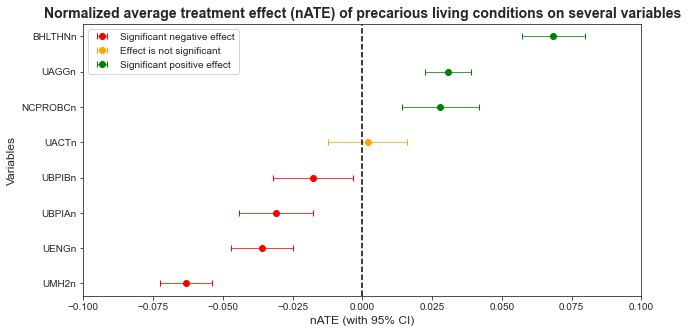

In [39]:
# Set the default color cycle
mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=['red', 'orange', 'green'])

plot_ATE(ate_precarious,'precarious')

We can look at each individual variable and make comments on its ATE:
- `BHLTHNn` has a relatively large significantly positive ATE. This means that living in a precarious household is positively associated with the poor health of children.

- `NCPROBCn` has a relatively large significantly positive ATE. This indicates that living in a precarious household is positively associated with a higher depression index for the child.
- `UAGGn` has a positive and significant ATE: this indicates that parents are generally more aggravated with their children if the household is precarious.
- `UBPIBn` and `UBPIAn` both exhibit a negative ATE. This means that precarity enhances the probability of having behavioral issues (remember that a higher score equals less problems). We can however notice that the ATE of `UBPIAn` (6-11 y.o.) is more pronounced than that of `UBPIBn` (12-17 y.o.). This gives us a hint that perhaps the ATEs of the subpopulations of children (segregation based on age range) are not exactly similar (_this is in fact the motivation for our third main aim_).
- `UENGn` exhibits a negative ATE: school engagement is generally lower for children from precarious households.
- `UMH2` has a relatively large significantly negative ATE. This means that parents in precarious housing tends to have worse mental health. We can compare with the ATE of `NCPROBCn` (which is also a mental health index, but for children) and conclude: as the absolute value of the average treatment effect $\mid$$ATE\mid$__*__ is larger for parents, we can infer that adults are more impacted than children by precarious housing. This could be due to the financial and administrative aspect that children are usually not subjected to.
- As expected, the control covariate included in the propensity score (`UACTn`) does not show any significant ATE, as this variable is supposedly matched equally between the two populations.  

__*__ the absolute value has to be taken because, while being two mental health indices, `NCPROBCn` and `UMH2n` do not follow the same scaling system (**1** means good mental health in `UMH2n`, but bad in `NCPROBCn`

# **3) Differential impact of precarity on children (6-11 y.o.) vs. adolescents (12-17 y.o.)**

Let's segregate the previous population into two and compute the multiple ATEs for each subpopulation (children vs. adolescents)

In [40]:
ate_precarious_fc2 = ATE_sch_hlth_happ(df_prec[df_prec['UAGE'] < 12],'precarious',['UENGn','BHLTHNn','UMH2n','UACTn','UAGGn','NCPROBCn'],fc2=True)
ate_precarious_fc2[['variable','Sample size','ATE','90% CI','95% CI','99% CI','Significance']]

UENGn
Number of matched subjects: 3130 / 3602
BHLTHNn
Number of matched subjects: 3154 / 3627
UMH2n
Number of matched subjects: 3164 / 3623
UACTn
Number of matched subjects: 3176 / 3627
UAGGn
Number of matched subjects: 3148 / 3627
NCPROBCn
Number of matched subjects: 3156 / 3617
UBPIAn
Number of matched subjects: 3146 / 3607


,variable,Sample size,ATE,90% CI,95% CI,99% CI,Significance
0,UENGn,3130,-0.029872,[-0.042610 ; -0.017135],[-0.045050 ; -0.014694],[-0.049819 ; -0.009925],***
1,BHLTHNn,3154,0.065472,[0.051701 ; 0.079244],[0.049063 ; 0.081882],[0.043906 ; 0.087038],***
2,UMH2n,3164,-0.063017,[-0.074375 ; -0.051660],[-0.076551 ; -0.049484],[-0.080803 ; -0.045232],***
3,UACTn,3176,0.005458,[-0.011710 ; 0.022625],[-0.014999 ; 0.025914],[-0.021427 ; 0.032342],Not significant
4,UAGGn,3148,0.028590,[0.018555 ; 0.038624],[0.016633 ; 0.040547],[0.012875 ; 0.044304],***
5,NCPROBCn,3156,0.042776,[0.026663 ; 0.058888],[0.023576 ; 0.061975],[0.017544 ; 0.068008],***
6,UBPIAn,3146,-0.031680,[-0.042773 ; -0.020588],[-0.044898 ; -0.018462],[-0.049052 ; -0.014309],***


In [41]:
ate_precarious_fc3 = ATE_sch_hlth_happ(df_prec[df_prec['UAGE'] >= 12],'precarious', ['UENGn','BHLTHNn','UMH2n','UACTn','UAGGn','NCPROBCn'],fc3=True)
ate_precarious_fc3[['variable','Sample size','ATE','90% CI','95% CI','99% CI','Significance']]

UENGn
Number of matched subjects: 2858 / 3253
BHLTHNn
Number of matched subjects: 2912 / 3305
UMH2n
Number of matched subjects: 2900 / 3298
UACTn
Number of matched subjects: 2900 / 3305
UAGGn
Number of matched subjects: 2902 / 3305
NCPROBCn
Number of matched subjects: 2886 / 3291
UBPIBn
Number of matched subjects: 2876 / 3286


,variable,Sample size,ATE,90% CI,95% CI,99% CI,Significance
0,UENGn,2858,-0.035748,[-0.050804 ; -0.020692],[-0.053688 ; -0.017807],[-0.059325 ; -0.012170],***
1,BHLTHNn,2912,0.066964,[0.052401 ; 0.081527],[0.049611 ; 0.084317],[0.044159 ; 0.089770],***
2,UMH2n,2900,-0.053720,[-0.065619 ; -0.041821],[-0.067898 ; -0.039541],[-0.072353 ; -0.035086],***
3,UACTn,2900,0.008966,[-0.009465 ; 0.027396],[-0.012995 ; 0.030926],[-0.019896 ; 0.037827],Not significant
4,UAGGn,2902,0.031760,[0.021219 ; 0.042300],[0.019200 ; 0.044319],[0.015253 ; 0.048266],***
5,NCPROBCn,2886,0.006237,[-0.012149 ; 0.024623],[-0.015671 ; 0.028145],[-0.022555 ; 0.035029],Not significant
6,UBPIBn,2876,-0.017327,[-0.029251 ; -0.005404],[-0.031535 ; -0.003120],[-0.035999 ; 0.001345],**


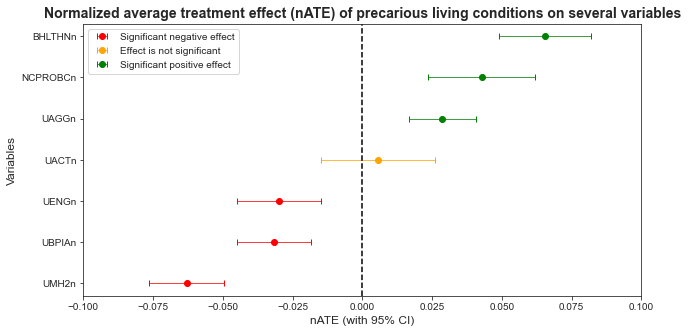

In [42]:
plot_ATE(ate_precarious_fc2,'precarious')

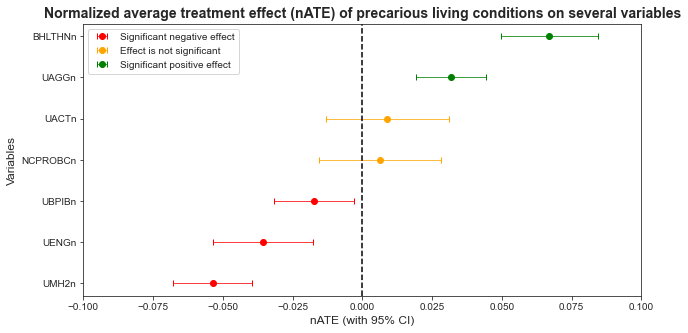

In [43]:
plot_ATE(ate_precarious_fc3,'precarious')

The two above figures show the ATEs for children (top) and adolescents (bottom).  
Let's now look for the difference in ATEs for the 2 subpopulations, in order to see which subgroup is more harshly impacted by precarity and for which outcome variables. We create a new dataframe `age_diff` containing the $\Delta ATE = ATE_{ado}-ATE_{child}$, their CIs and significance. We then reuse our `plot_ATE` method in order to visualize the 95% intervals for the different $\Delta ATE$s.  
Reminder of the CI for the difference between two means (here sample sizes $n_1 \neq n_2$):
$$CI_{\alpha} : (\overline{x_1}-\overline{x_2})\pm Z_{\alpha/2}\cdot SE \rightarrow SE=\sqrt{\frac{(n_1-1)\cdot s_1^2+(n_2-1)\cdot s_2^2}{n_1+n_2-2}}\cdot\sqrt{\frac{1}{n_1}+\frac{1}{n_2}}$$  

In [44]:
age_diff = pd.DataFrame(ate_precarious_fc3.variable)
age_diff.variable.iloc[6] ='UBPIn'
ci90s = []
ci95s = []
ci99s = []
# z-values for the 3 CIs
zs = [st.norm.ppf(1-0.1/2), st.norm.ppf(1-0.05/2), st.norm.ppf(1-0.01/2)]
for i in range (0,ate_precarious_fc3.variable.size):
    ate = ate_precarious_fc3['ATE'][i] - ate_precarious_fc2['ATE'][i]
    age_diff.loc[i,'ATE'] = ate
    
    # sample numbers
    n1=ate_precarious_fc2['Sample size'][i]
    s1=ate_precarious_fc2['Std. Dev'][i]
    n2=ate_precarious_fc3['Sample size'][i]
    s2=ate_precarious_fc3['Std. Dev'][i]
    
    # standard deviation of a difference of samples
    se=np.sqrt(((n1-1)*s1*s1 + (n2-1)*s2*s2)/(n1+n2-2))*np.sqrt(1/n1 + 1/n2)
 
    # ci qui utilise la moitié de la taille de ci que les précédents: 
    ci = [(ate-zs[0]*se,ate+zs[0]*se),(ate-zs[1]*se,ate+zs[1]*se),(ate-zs[2]*se,ate+zs[2]*se)]
    
    ci90s.append(ci[0])
    ci95s.append(ci[1])
    ci99s.append(ci[2])
    age_diff.loc[i,'n1, n2'] = '('+str(n1)+' ; '+str(n2)+')'
    age_diff.loc[i,'Significance'] = stars(ci)
    age_diff.loc[:,'sig95'] = age_diff['Significance'].apply(lambda x : 2 if (x=='**' or x=='***') else 0) + age_diff['ATE'].apply(lambda x : 1 if x > 0 else 0)
    age_diff['sig95'].replace({3 : 'Significant positive effect', 2 : 'Significant negative effect',
                             1 : 'Effect is not significant', 0 : 'Effect is not significant'}, inplace=True)
age_diff['ci90'] = ci90s
age_diff['ci95'] = ci95s
age_diff['ci99'] = ci99s

# nice display of confidence intervals
for i in range(3):
    col = ['ci90','ci95','ci99']
    col_fmd = ['90% CI','95% CI','99% CI']
    age_diff.loc[:,col_fmd[i]] = age_diff[col[i]].apply(lambda x : '['+ '{:.6f}'.format(x[0],6)+' ; '+ '{:.6f}'.format(x[1],6)+']')

In [45]:
age_diff.rename(columns={"ATE": "$\Delta ATE$"})[['variable','n1, n2','$\Delta ATE$','90% CI','95% CI','99% CI','Significance']]

,variable,"n1, n2",$\Delta ATE$,90% CI,95% CI,99% CI,Significance
0,UENGn,(3130 ; 2858),-0.005875,[-0.019740 ; 0.007989],[-0.022396 ; 0.010645],[-0.027587 ; 0.015837],Not significant
1,BHLTHNn,(3154 ; 2912),0.001492,[-0.012261 ; 0.015244],[-0.014895 ; 0.017879],[-0.020045 ; 0.023028],Not significant
2,UMH2n,(3164 ; 2900),0.009298,[-0.002249 ; 0.020844],[-0.004461 ; 0.023056],[-0.008784 ; 0.027379],Not significant
3,UACTn,(3176 ; 2900),0.003508,[-0.011537 ; 0.018553],[-0.014419 ; 0.021435],[-0.020052 ; 0.027068],Not significant
4,UAGGn,(3148 ; 2902),0.003170,[-0.007177 ; 0.013517],[-0.009159 ; 0.015500],[-0.013034 ; 0.019374],Not significant
5,NCPROBCn,(3156 ; 2886),-0.036539,[-0.053856 ; -0.019221],[-0.057174 ; -0.015903],[-0.063658 ; -0.009419],***
6,UBPIn,(3146 ; 2876),0.014353,[0.002678 ; 0.026029],[0.000441 ; 0.028265],[-0.003931 ; 0.032637],**


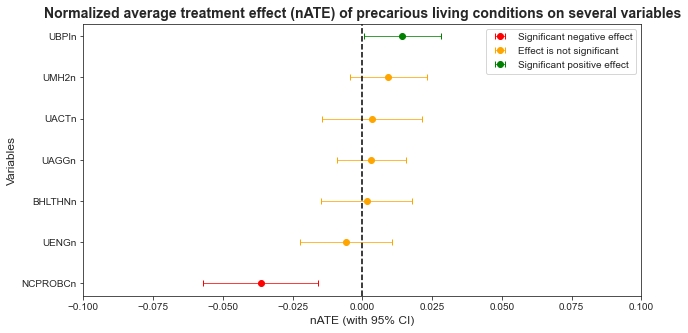

In [46]:
plot_ATE(age_diff,'precarious')

We can see that most variables are not significantly affected by the age group. Let us note that variables that have a negative $\Delta ATE$ means that their ATE is higher in children than adolescents, and those with a positive $\Delta ATE$ have a bigger ATE for adolescents.  
The most striking differences are:
- `NCPROBCn`: ATE is bigger in children: precarious housing impacts children's mental health more negatively than adolescents'.
- `UBPIn`: Adolescents exhibit a higher behavioral problem index (= less problems) compared to children. This means that precarious housing impacts adolescents' behavior less harshly than it does children's.

We can conclude that overall, mental health is the only outcome variable (from education, mental health, physical health) that sees a significant disparity between the two age groups. Indeed, children (<12 y.o.) have their mental health more harshly affected (than adolescents) by precarious conditions.

---

# **Conclusion ?**